In [137]:
import numpy as np
import geog
import pandas as pd
import geopandas as gpd
import csv
import shapely
from shapely.geometry import Point
from shapely.geometry import Polygon
import datetime

In [83]:
inputFileName = '../../rawdata/school_location/schools.csv'
outputFileName = '../../data/schools/schools.csv'

In [90]:
# reading CSV
dframe = pd.read_csv(inputFileName)

In [91]:
colnames = ['Location 1']
dframe = dframe[colnames]

#  removing the address. Keeping only the coordinates.
dframe['Location 1'] = dframe['Location 1'].apply(lambda location: str(location)[ (str(location).find('(') + 1) : str(location).find(')')])
dframe['Location 1'] = dframe['Location 1'].apply(lambda coords: str(coords).split(','))

In [92]:
# putting lat and lon in separate fields
dframe['lat'] = dframe['Location 1'].apply( lambda coords: coords[0] )
dframe['lon'] = dframe['Location 1'].apply( lambda coords: 'null' if len(coords) < 2 else str(coords[1]).strip() )

In [97]:
# saving in a CSV file
dframe = dframe[['lat', 'lon']]
dframe['lat'] = pd.to_numeric(dframe['lat'], errors='coerce')
dframe['lon'] = pd.to_numeric(dframe['lon'], errors='coerce')
dframe.dropna(inplace=True)

# dframe.to_csv(outputFileName, index=False, quoting=csv.QUOTE_NONNUMERIC)

In [101]:
dframe.head()

,lat,lon,geometry
0,40.722075,-73.978747,POINT (-73.978747 40.722075)
1,40.730009,-73.984496,POINT (-73.98449599999999 40.730009)
2,40.721305,-73.986312,POINT (-73.986312 40.721305)
3,40.726008,-73.975058,POINT (-73.97505799999999 40.726008)
4,40.724440,-73.986214,POINT (-73.986214 40.72444)


In [102]:
# converting dFrame to geodataframe
dframe['geometry'] = dframe.apply(lambda row: shapely.geometry.Point( row['lon'], row['lat'] ), axis=1 )
dframe_geodf = gpd.GeoDataFrame(dframe, crs={'init' : 'epsg:4326'}, geometry='geometry')
dframe_geodf = dframe_geodf.to_crs({'init':'epsg:3857'})

## Extracting timeseries for each sensor

In [11]:
sensorCoordsPath = '../../data/sensors/sensor_coords.txt'

In [ ]:
sensorsCoords = open(sensorCoordsPath)

for line in sensorsCoords:
    
    sensorID, lat, lon = line.split(' ')
    
    lat = float(lat)
    lon = float(lon)
    
    spatialFilter = spatialJoin(dframe_geodf, lat, lon)

## Helper Functions

In [175]:
timeseries = generateTimeseries(2)

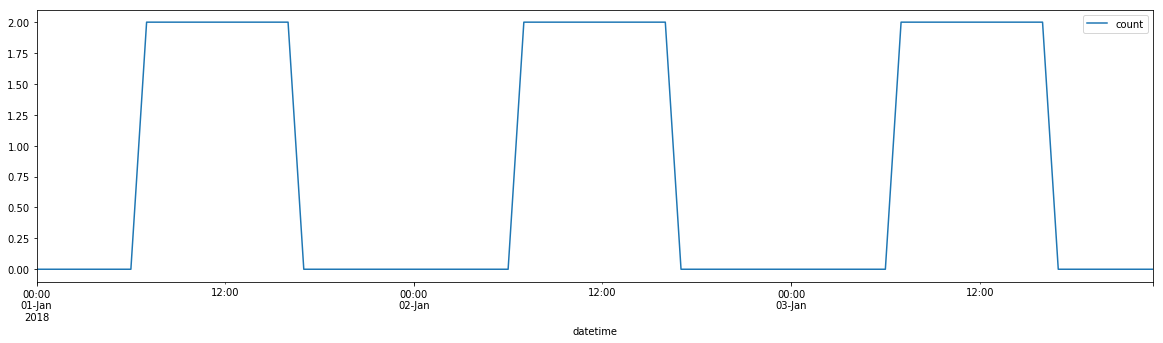

In [181]:
timeseries['2018-01-01':'2018-01-03'].plot(figsize=(20,5))

In [174]:
def spatialJoin(geoDataframe, lat, lon):
    
    d = 200 # meters
    n_points = 20
    angles = np.linspace(0, 360, n_points)
    center = shapely.geometry.Point(lon,lat)
    polygon = Polygon(geog.propagate(center, angles, d))
    
    sinpoly = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
    sinpoly = sinpoly.append({'geometry': polygon}, ignore_index=True) 
    sinpoly = sinpoly.to_crs({'init':'epsg:3857'})
    
    dataframe = gpd.tools.sjoin(geoDataframe, sinpoly, how='inner', op="within")
    
    return dataframe


def generateTimeseries(nSchools):
    
    timeseries = pd.DataFrame()
    timeseries['datetime'] = pd.date_range('2018-01-01 00:00:00', '2018-12-31 23:00:00', freq='1h')
    timeseries.set_index('datetime', inplace=True)
    timeseries['count'] = 0
    
    startDate = datetime.datetime(year=2018, month=1, day=1)
    endDate = datetime.datetime(year=2018, month=12, day=31)
    
    hour = datetime.timedelta(hours=1)
    
    while(endDate > startDate):
        
        if( startDate.hour >= 7 and startDate.hour <= 16):
            
            timeseries.loc[startDate]['count'] = nSchools
            
        startDate = startDate + hour
            
    return timeseries